In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Concatenate, BatchNormalization, DepthwiseConv2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Lambda, Reshape, Layer, Activation, add
from tensorflow.keras import layers 
from math import ceil
import numpy as np

In [10]:
def VGG16():
  input_shape = (32, 32, 3)
  model = Sequential([
    Conv2D(64, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    Conv2D(256, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    Conv2D(512, (3, 3), activation='relu', padding='same',),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(10, activation='softmax')
    ])
  return model

In [3]:
def scheduler(epoch):
  learning_rate = 0.01
  if epoch < epoch_num * 0.4:
      return learning_rate
  if epoch < epoch_num * 0.8:
      return learning_rate * 0.1
  return learning_rate * 0.01

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [6]:
IMAGE_SIZE = 32
batch_size = 64
epoch_num = 70
AUTO = tf.data.AUTOTUNE

In [7]:
simple_aug = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

test_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .shuffle(64 * 100)
    .batch(64)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
) 

In [8]:
change_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [11]:
model = VGG16()
model.build(input_shape = (1, 32, 32, 3))
model.summary()
checkpoint = tf.train.Checkpoint(myModel=model)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(train_ds_simple,
          batch_size=batch_size,
          epochs=epoch_num,
          callbacks=[change_lr],
          validation_data=test_ds_simple)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)        

In [13]:
model.metrics_names

['loss', 'accuracy']

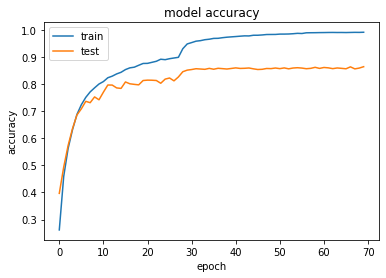

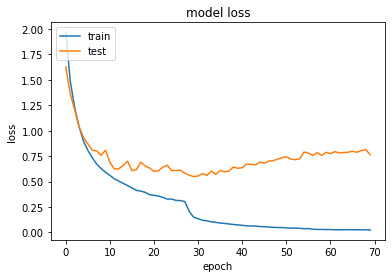

In [14]:
# summarize history for accuracy
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
checkpoint.save('/content/drive/MyDrive/Colab Notebooks/2021/paper/gostnet/weight/VGG16/model.ckpt')

'/content/drive/MyDrive/Colab Notebooks/2021/paper/gostnet/weight/VGG16/model.ckpt-1'